In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import *
from keras.utils import np_utils
from nltk.tokenize import RegexpTokenizer
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.feature_extraction import text as sktext
from sklearn import preprocessing as skp
from keras import callbacks as kc
from keras import optimizers as ko
from keras import initializers, regularizers, constraints
from keras.engine import Layer
import keras.backend as K
from sklearn.metrics import f1_score
from keras.utils.vis_utils import model_to_dot
from keras import models
from keras import layers
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, Flatten, GlobalAveragePooling1D, Reshape
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import Constant


Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
df = pd.read_csv('final_HEOT_data.csv')

In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,label,tweet,tokens,stem,lemmas,text
0,0,0,0.0,@saud5683 @Mutayyab420 @shivang598 @Ranask35 @...,"['user', 'user', 'user', 'user', 'user', 'user...",us us us us us us us us haa jais tum bhi abh p...,user user user user user user user user haa ja...,User user user user user user user user yes li...
1,1,2,2.0,"Banti hai empowered woman, feminism pe gyan pe...","['banti', 'hai', 'empowered', 'woman', 'femini...",bant hai empow wom femin pe gyan pelt hai aur ...,banti hai empower woman feminism pe gyan pelti...,Becomes Empowered Woman Feminism thrives and w...
2,2,4,2.0,RT @kim_jong_korea: @updatingwait @Acutereply ...,"['rt', 'user', 'user', 'user', 'ab', 'usko', '...",rt us us us ab usko chhod mjse bat kr ter baap...,rt user user user ab usko chhod mjse bat kr te...,"Rat user, user, user, leave him now, which thi..."
3,3,6,2.0,@InviSibleSold @mabkhan86 @dridadahn Punjab in...,"['user', 'user', 'user', 'punjab', 'in', 'mada...",us us us punjab in madarchodon ko khil rah hai...,user user user punjab in madarchodon ko khila ...,USER USER USER PUNJAB FEATURING MADARCHODO IS ...
4,4,8,2.0,RT @MrMonsterSaid: Agar koi bole ki ja ke chil...,"['rt', 'user', 'agar', 'koi', 'bole', 'ki', 'j...",rt us ag koi bol ki ja ke chil maar to madarch...,rt user agar koi bole ki ja ke chill maar to m...,"Rat user if someone says to kill, then to kill..."


In [5]:
df['label'] = df['label'].astype(int)

In [6]:
df = df.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)

In [7]:
train_df = pd.DataFrame()
train_df['content'] = df['lemmas']
train_df['class'] = df['label']

Training data phrase length distribution


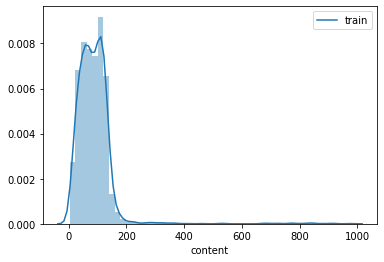

In [8]:
print("Training data phrase length distribution")
sns.distplot(train_df['content'].map(lambda ele: len(ele)), kde_kws={"label": "train"})

In [9]:
print('Most frequent sentence length in training:')
lens = train_df['content'].map(lambda ele: len(ele))
counts = np.bincount(lens)
print(np.argmax(counts))

Most frequent sentence length in training:
55


Testing data phrase length distribution


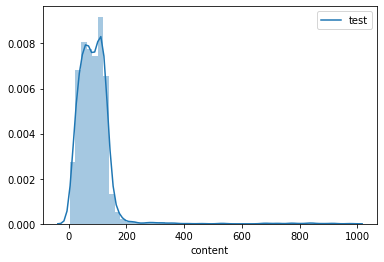

In [10]:
print("Testing data phrase length distribution")
sns.distplot(train_df['content'].map(lambda ele: len(ele)), kde_kws={"label": "test"})

In [11]:
train_df.shape

(3189, 2)

In [12]:
test_df = train_df[2800:]
train_df = train_df[:2800]

Testing data phrase length distribution


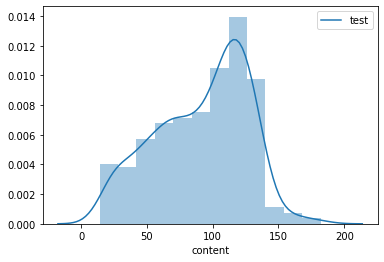

In [13]:
print("Testing data phrase length distribution")
sns.distplot(test_df['content'].map(lambda ele: len(ele)), kde_kws={"label": "test"})

In [14]:
print('Most frequent sentence length in testing:')
lens = test_df['content'].map(lambda ele: len(ele))
counts = np.bincount(lens)
print(np.argmax(counts))

Most frequent sentence length in testing:
115


In [15]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [16]:

## A dictionary to map the punctuations present in the text to relevant strings or symbols
punct_mapping = {"‘": "'", 
                 "₹": "e", 
                 "´": "'", 
                 "°": "", 
                 "€": "e", 
                 "™": "tm",
                 "√": " sqrt ",
                 "×": "x",
                 "²": "2",
                 "—": "-",
                 "–": "-",
                 "’": "'",
                 "_": "-",
                 "`": "'",
                 '“': '"',
                 '”': '"',
                 '“': '"',
                 "£": "e",
                 '∞': 'infinity',
                 'θ': 'theta',
                 '÷': '/',
                 'α': 'alpha',
                 '•': '.',
                 'à': 'a',
                 '−': '-',
                 'β': 'beta',
                 '∅': '',
                 '³': '3',
                 'π': 'pi',
                 ',':'',
                 '.':'',
                 ':':'',
                 '(':'',
                 ')':'',
                 '*':'',
                '"':'',
                '<':'',
                '>':''}

In [17]:
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

## Function to remove special characters from the sentences (if any present)
def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

In [18]:
train_df.loc[:, 'content'] = train_df['content'].map(lambda text: clean_special_chars(text, punct, punct_mapping))
test_df.loc[:, 'content'] = test_df['content'].map(lambda text: clean_special_chars(text, punct, punct_mapping))

In [19]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [20]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [21]:
train_df.loc[:, 'content'] = train_df['content'].map(lambda text: clean_contractions(text, contraction_mapping))
test_df.loc[:, 'content'] = test_df['content'].map(lambda text: clean_contractions(text, contraction_mapping))

In [22]:
train_df.loc[:, 'content'] = train_df['content'].map(lambda text: text.lower())
test_df.loc[:, 'content'] = test_df['content'].map(lambda text: text.lower())

In [23]:
data = train_df.values
data_test = test_df.values

In [24]:
X_train = data[:,0]
Y_train = data[:,1]

X_test = data_test[:,0]
Y_test = data_test[:,1]

print (X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
print ("-------------------------")
print (X_test[0], Y_test[0])
print (X_train[0], Y_train[0])

(2800,) (2800,) (389,) (389,)
-------------------------
itna maar khayega man why do not you understand 0
user user user user user user user user haa jaise tum bhi abhi pxe2x80xa6 url 0


In [25]:
tokenizer = RegexpTokenizer("[a-zA-Z]+")
lemmatizer = WordNetLemmatizer()

In [26]:
for ix in range(X_train.shape[0]):
    X_train[ix] = tokenizer.tokenize(X_train[ix])
    X_train[ix] = [lemmatizer.lemmatize(i) for i in X_train[ix]]
    
for ix in range(X_test.shape[0]):
    X_test[ix] = tokenizer.tokenize(X_test[ix])
    X_test[ix] = [lemmatizer.lemmatize(i) for i in X_test[ix]]

In [27]:

unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
#     print(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
## Length of the list of unique_words gives the no of unique words
print("Vocabulary Size:")
print(len(list(unique_words)))
print("Maximum length of sentence:")
print(len_max)

100%|██████████| 2800/2800 [00:00<00:00, 791484.78it/s]

Vocabulary Size:
7656
Maximum length of sentence:
295


In [28]:
tokenizer_keras = Tokenizer(num_words=len(list(unique_words)))
tokenizer_keras.fit_on_texts(list(X_train))
X_train = tokenizer_keras.texts_to_sequences(X_train)
X_test = tokenizer_keras.texts_to_sequences(X_test)

## Padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
## Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.
X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)
print(X_train.shape,X_test.shape)

(2800, 295) (389, 295)


In [29]:
embeddings_index = dict()

In [30]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts

In [31]:
model = Word2Vec.load("word2vec.model")

In [32]:
word_vectors = model.wv

In [33]:
print(data[:,0])

[list(['user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'haa', 'jaise', 'tum', 'bhi', 'abhi', 'pxe', 'x', 'xa', 'url'])
 list(['banti', 'hai', 'empower', 'woman', 'feminism', 'pe', 'gyan', 'pelti', 'hai', 'aur', 'din', 'bhar', 'roti', 'rehti', 'hai', 'pahle', 'rona', 'band', 'kar', 'madarchod'])
 list(['rt', 'user', 'user', 'user', 'ab', 'usko', 'chhod', 'mjse', 'bat', 'kr', 'tera', 'baap', 'aa', 'gya', 'hai', 'ab', 'to', 'ldki', 'ko', 'beech', 'me', 'q', 'la', 'ra', 'hai', 'madarchod', 'txe', 'x', 'xa'])
 ... list(['bjp', 'will', 'win', 'jai', 'ram', 'modi', 'bhagwan'])
 list(['kya', 'karna', 'hai', 'ab', 'bol'])
 list(['sab', 'mar', 'jayenge', 'ba', 'main', 'zinda', 'rahunga'])]


In [34]:
embeddings_index = dict()

In [35]:
for sent in data[:,0]:
    for token in sent:
        word = token
        word = lemmatizer.lemmatize(word)
        try:
            coefs = np.asarray(word_vectors[word], dtype='float32')
#             print(coefs)
#             print(coefs.shape)
            embeddings_index[word] = coefs
        except:
            print(word)
            coefs = np.zeros((200,))
            embeddings_index[word] = coefs

pxe
txe
maxe
haixe
bhaxe
haxe
month
throwxe
chukexe
singalxe
xf
fx
xe
compaxe
madarchodbharxe
bhoktixe
madarchodxe
rallxe
chuxe
nexe
priest
xe
hxe
madarchxe
xf
fxa
chodxe
rxe
xf
fx
xf
fx
xf
fx
mentionxe
txe
yahaxe
kahixe
fuckixe
karxe
baaxe
xf
fx
cxf
fx
cxf
fx
cxf
fx
cxf
fx
cxf
fx
cxf
fx
cxf
fx
cxf
fx
mentionxe
sexe
dxe
haixe
xf
fx
cxf
fx
cxf
fx
cxf
fx
cxf
fx
hxe
motherfucker
urxe
bhotxf
fx
xf
fx
xf
fx
xf
fx
xf
fx
kxe
bahenchodxf
fx
daxe
bhaxe
baxe
xf
fx
xf
fx
fikxe
goon
statistic
startup
pataxe
haixf
fx
xf
fx
xf
fx
xf
fx
haixf
fx
xf
fx
saxe
nahixe
kuttaxe
fromxe
haixe
sakxe
haixf
fx
xf
fx
xf
fx
xf
fx
haixf
fx
xf
fx
katvexe
kixe
kadvaxe
hexe
bxe
shxe
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
axa
xf
fx
axa
pxe
thexe
woxe
mentionxe
merxe
nahinnrepxe
musalmanoxe
mentionxe
kabhixe
parwahxe
virodhxe
pataxe
kaxf
fx
xf
fx
chuxe
xf
fx
timexf
fx
mentionxe
mentionxe
haxe
mentionxe
naxe
mentionxe
abxe
merxe
mentionxe
chodraxe
tabxe
kixe
terxe
kexe
redxe
laxe
mentionxe
nupxe
mentionxe
choxe
daaxe
xe
bac

xbaxb
nhxc
chxc
xbat
mxc
xc
xc
dokolxc
dujestli
mxc
xc
chuxc
nje
pohodxc
bnjsi
krxc
snxc
xbdxc
nbudou
vxc
noce
kxe
xf
fx
fxe
paglaxe
chutxe
xe
yadxf
fx
xf
fx
xf
fx
xf
fx
kaxe
mentionxe
bxe
hainnnmerxe
kxe
openxe
baanxe
huixf
fx
dxf
fx
dxf
fx
xf
fx
xf
fx
xf
fx
dxb
fxb
xebxb
cxebxa
xecxb
bxa
xeaxb
xebxb
xebxa
xeaxb
xeaxb
dxbcxebx
bxa
bx
xeaxb
xeaxb
fxacxeaxb
fx
axa
xebxa
axb
fxb
dxb
xeaxb
xeaxb
fxb
xecxa
fx
xecxb
bx
cxecx
xecxb
xebxa
dx
xf
fx
bxf
fx
httpsxe
xe
bx
cxebxa
fx
xebxa
xecxb
xbexecx
xebxb
xeaxb
dxe
xe
xe
dxe
xe
xe
xe
chilaayeginxe
bechxe
hamarixe
terixe
mentionxe
maxe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xabxe
xe
xe
xe
xe
xe
xe
xe
xe
exe
xe
xe
xadxe
xe
xe
xadxe
xe
xabxe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
axe
xe
xe
xe
exe
xe
xe
xadxe
xe
xe
xe
xe
xe
xe
xadxe
axe
xe
xe
xe
degexe
xe
xe
dxe
xe
xe
xe
aulaxe
cxe
bechxe
xe
xe
xe
xe
xacxe
xbexe
xacxe
xbe
resource
nxe
xacxebx
bxb
xebxb
axa
xeaxb
bxa
xebxa
xacxebx
ax
xacxebx
cxebx
xecxa
xebxb
ax
huixf
fx
dxf


xe
xbexe
karoungaxf
fx
xf
fx
retxe
ladxe
karoungaxf
fx
httxe
mentionxe
xe
xaaxe
xe
xbcxe
bxe
xe
xe
xadxe
xbexe
xadxe
xe
xe
xe
xabxe
dxe
xe
xe
xe
dxe
xaaxe
xe
dxe
xe
xe
bxe
xe
xe
xe
xe
xbfxe
xafxe
xbe
nightxf
fx
xf
fx
xf
fx
xf
fx
mentionxe
aisixf
fx
xbbxf
fx
xbbxf
fx
xbbxf
fx
mentionxe
bhukhixe
xf
fx
mentionxe
xf
fx
xf
fx
xf
fx
mentionxe
xf
fx
baxe
xf
fx
xf
fx
xf
fx
xf
fx
cuntsxe
imbecile
axe
xf
fx
xf
fx
xf
fx
xf
fxa
xf
fx
fxbcxe
dxe
xefxb
fxf
fxa
xf
fx
fxbcxe
dxe
xefxb
fxf
fxa
xf
fx
fxbcxe
dxe
xefxb
bitxe
youxe
xf
fx
xf
fx
hxe
xe
cbusy
cuntxe
hexe
xe
fxafxe
bxe
xbfxe
enxefxbcxbcxe
fxe
dxe
xbfx
xe
xe
fxefxbcx
xe
celebratingxe
moxe
anxe
xe
xbdxe
xe
fxe
xaaxe
xe
xe
bxe
xe
xe
xe
xacx
nxefxbcxbcxe
xe
xe
thexe
theirxe
xe
xe
xefxbdxb
exefxbdxb
exefxbdxb
exefxbdxb
exefxbdxb
exefxbdxb
exefxbdxb
exefxbdxb
exefxbdxb
exefxbdxb
exe
nxefxbcxbcxe
exe
xaaxe
xaaxe
bxe
cuntnnxf
fx
xc
dommesxf
fx
min
chipperxe
xe
ca
cuntxe
xe
ca
knobxe
txe
hisxe
xf
fx
dx
xf
fx
dx
xf
fx
dx
xf
fx
dx
hashtagxe
xf
fx
xf
fx
x

In [36]:

lists = [
    ['maa', 'behen', 'beti'],
    ['jews', 'extremists', 'militants', 'terrorist', 'terror', 'militant', 'violence', 'corrupt'],
    ['arabs', 'extremists', 'militants', 'terrorist', 'terror', 'militant', 'violence', 'corrupt'],
    ['muslims', 'extremists', 'militants', 'terrorist', 'terror', 'militant', 'violence', 'corrupt'],
    ['islamic', 'extremists', 'militants', 'terrorist', 'terror', 'militant', 'violence', 'corrupt'],
    ['mulle', 'machod', 'manhoos', 'chutiya']
]

In [37]:
pairs = []
for lst in lists:
    for i in range(1, len(lst)):
        pairs.append([lst[0],lst[i]])

In [38]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similariy between u and v
        
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
    
    distance = 0.0
    
    # Compute the dot product between u and v 
    dot = np.dot(u,v)
    # Compute the L2 norm of u 
    norm_u = np.linalg.norm(u)
    
    # Compute the L2 norm of v 
    norm_v = np.linalg.norm(v)
    # Compute the cosine similarity defined by formula (1) 
    cosine_similarity = dot / (norm_u*norm_v)
    
    return cosine_similarity

In [39]:
def neutralize(word, g, word_to_vec_map):
    """
    Removes the bias of "word" by projecting it on the space orthogonal to the bias axis. 
    This function ensures that gender neutral words are zero in the gender subspace.
    
    Arguments:
        word -- string indicating the word to debias
        g -- numpy-array of shape (50,), corresponding to the bias axis (such as gender)
        word_to_vec_map -- dictionary mapping words to their corresponding vectors.
    
    Returns:
        e_debiased -- neutralized word vector representation of the input "word"
    """
    
    # Select word vector representation of "word". Use word_to_vec_map. 
    e = word_to_vec_map[word]
    
    # Compute e_biascomponent using the formula give above. 
    e_biascomponent = np.dot(e,g)*g/(np.linalg.norm(g)**2)
 
    # Neutralize e by substracting e_biascomponent from it 
    # e_debiased should be equal to its orthogonal projection. 
    e_debiased = e - e_biascomponent
    
    return e_debiased

In [40]:
def equalize(pair, bias_axis, word_to_vec_map):
    """
    Debias gender specific words by following the equalize method described in the figure above.
    
    Arguments:
    pair -- pair of strings of gender specific words to debias, e.g. ("actress", "actor") 
    bias_axis -- numpy-array of shape (50,), vector corresponding to the bias axis, e.g. gender
    word_to_vec_map -- dictionary mapping words to their corresponding vectors
    
    Returns
    e_1 -- word vector corresponding to the first word
    e_2 -- word vector corresponding to the second word
    """
    
    # Step 1: Select word vector representation of "word". Use word_to_vec_map. 
    w1, w2 = pair
    e_w1, e_w2 = word_to_vec_map[w1],word_to_vec_map[w2]
    
    # Step 2: Compute the mean of e_w1 and e_w2
    mu = (e_w1+e_w2)/2

    # Step 3: Compute the projections of mu over the bias axis and the orthogonal axis 
    mu_B = np.dot(mu,bias_axis)*bias_axis/np.linalg.norm(bias_axis)**2
    mu_orth = mu-mu_B

    # Step 4: Use equations (7) and (8) to compute e_w1B and e_w2B
    e_w1B = np.dot(e_w1,bias_axis)*bias_axis/np.linalg.norm(bias_axis)**2
    e_w2B = np.dot(e_w2,bias_axis)*bias_axis/np.linalg.norm(bias_axis)**2
        
    # Step 5: Adjust the Bias part of e_w1B and e_w2B using the formulas (9) and (10) given above
    corrected_e_w1B = np.sqrt(abs(1-np.linalg.norm(mu_orth)**2))*(e_w1B-mu_B)/(abs(e_w1-mu_orth-mu_B))
    corrected_e_w2B = np.sqrt(abs(1-np.linalg.norm(mu_orth)**2))*(e_w2B-mu_B)/(abs(e_w2-mu_orth-mu_B))

    # Step 6: Debias by equalizing e1 and e2 to the sum of their corrected projections
    e1 = corrected_e_w1B+mu_orth
    e2 = corrected_e_w2B+mu_orth
    
    return e1, e2


In [41]:
for pair in pairs:
    try:
        w1 = pair[0]
        w2 = pair[1]
        g = embeddings_index[w2] - embeddings_index[w1]
        e1, e2 = equalize((w1, w2), g, embeddings_index)
        embeddings_index[w1] = e1
        embeddings_index[w2] = e2
    except:
        pass

In [42]:
len(embeddings_index)

7654

In [43]:
vocab_size=len(list(unique_words))
embedding_matrix = np.zeros((vocab_size+1, 200))
for word, i in tokenizer_keras.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [44]:
embed_size = 200
max_features = vocab_size + 1 

In [45]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [46]:
text_input_layer = Input(shape=(len_max,), dtype='int32')
doc_embedding   = Embedding(len(list(unique_words))+1,
                            200,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=len_max,
                            trainable=False)(text_input_layer)

convs = []
filter_sizes = [4, 5]
# filter_sizes = [5]

l_conv = Conv1D(filters=128, kernel_size=[3], padding='valid', activation='relu')(doc_embedding)

for filter_size in filter_sizes:
    l_conv = Conv1D(filters=128, kernel_size=filter_size, padding='valid', activation='relu')(l_conv)
    convs.append(l_conv)
cnn_feature_maps = convs

reg_drop = Dropout(0.3)(l_conv)
# flat = Flatten()(reg_drop)
sentence_encoder1 = Bidirectional(LSTM(128,return_sequences=True))(reg_drop)
sentence_encoder2 = Bidirectional(LSTM(128,return_sequences=True))(sentence_encoder1)
att = Attention(286)(sentence_encoder2)
fc_layer =Dense(128, activation="relu")(att)
output_layer = Dense(3,activation="softmax")(fc_layer)

model_1 = Model(inputs=[text_input_layer], outputs=[output_layer])

W0902 15:21:36.582242 140467841972032 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0902 15:21:36.594680 140467841972032 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0902 15:21:36.628590 140467841972032 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0902 15:21:36.659045 140467841972032 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is depre

In [47]:
checkpoint=ModelCheckpoint('model_self_embedding_final.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [48]:
X_full = np.concatenate((X_train, X_test))
Y_full = np.concatenate((Y_train, Y_test))

In [49]:
Y_full = np_utils.to_categorical(Y_full)

In [50]:
from sklearn import model_selection
x_train, x_test, y_train, y_test = model_selection.train_test_split(X_full, Y_full, random_state=3, test_size=0.2)

In [51]:
model_1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model_1.summary()

W0902 15:21:39.082884 140467841972032 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0902 15:21:39.087841 140467841972032 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 295)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 295, 200)          1531400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 293, 128)          76928     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 290, 128)          65664     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 286, 128)          82048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 286, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 286, 256)          2631

In [52]:
file_path = "weights_base_[C-LSTM].best.hdf5"
early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=10)
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=2, save_best_only=True, mode='max')

In [53]:
hist = model_1.fit(x_train,y_train,validation_data=(x_test,y_test),
                epochs = 10, batch_size=16,shuffle=True,callbacks=[checkpoint,early_stopping])

W0902 15:21:40.019082 140467841972032 deprecation.py:323] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2551 samples, validate on 638 samples
Epoch 1/10


KeyboardInterrupt: 

In [54]:
pred_val = model_1.predict(x_test)

In [55]:
pred_val = pred_val.argmax(axis=1)

In [56]:
true = y_test.argmax(axis=1)

In [57]:
final = pd.DataFrame()
final['true'] = true.astype(int)
final['pred'] = pred_val.astype(int)

In [58]:
f1_score(final['true'],final['pred'], average=None)

array([0.48704663, 0.06993007, 0.05540166])

In [59]:
print(classification_report(final['true'], final['pred']))

              precision    recall  f1-score   support

           0       0.34      0.83      0.49       227
           1       0.06      0.08      0.07        64
           2       0.71      0.03      0.06       347

    accuracy                           0.32       638
   macro avg       0.37      0.31      0.20       638
weighted avg       0.52      0.32      0.21       638



In [60]:
output1 = model_1.layers[-2].output
# dense2 = Dense(300, activation='relu', name='layer_2')(output1)
input4 = Input(shape=(209,))
dense3 = Dense(50, activation='relu', name='layer_3')(input4)
merged = concatenate([output1, dense3])
pre_final = Dense(50, activation='relu', name='pre_final')(merged)
output = layers.Dense(3, activation="softmax", name="softmax_layer0")(pre_final)

In [61]:
model_fin = Model(inputs = [model_1.input, input4], outputs = [output])

In [62]:
abuse_full = np.load('Abuse_Features_HEOT.npy')

In [63]:
model_fin.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model_fin.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 295)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 295, 200)     1531400     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 293, 128)     76928       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 290, 128)     65664       conv1d_1[0][0]                   
____________________________________________________________________________________________

In [64]:
abuse_train, abuse_test, y_train, y_test = model_selection.train_test_split(abuse_full, Y_full, random_state=3, test_size=0.2)

In [65]:
hist = model_fin.fit([x_train,abuse_train],y_train,validation_data=([x_test,abuse_test],y_test),
                epochs = 10, batch_size=16,shuffle=True,callbacks=[checkpoint,early_stopping])

Train on 2551 samples, validate on 638 samples
Epoch 1/10
2551/2551 [==============================] - 222s 87ms/step - loss: 0.6995 - acc: 0.7448 - val_loss: 0.5315 - val_acc: 0.8354

Epoch 00001: val_acc improved from -inf to 0.83542, saving model to weights_base_[C-LSTM].best.hdf5
Epoch 2/10
2551/2551 [==============================] - 220s 86ms/step - loss: 0.5040 - acc: 0.8295 - val_loss: 0.4450 - val_acc: 0.8511

Epoch 00002: val_acc improved from 0.83542 to 0.85110, saving model to weights_base_[C-LSTM].best.hdf5
Epoch 3/10
2551/2551 [==============================] - 223s 88ms/step - loss: 0.4560 - acc: 0.8420 - val_loss: 0.4132 - val_acc: 0.8605

Epoch 00003: val_acc improved from 0.85110 to 0.86050, saving model to weights_base_[C-LSTM].best.hdf5
Epoch 4/10
2551/2551 [==============================] - 219s 86ms/step - loss: 0.4212 - acc: 0.8483 - val_loss: 0.4054 - val_acc: 0.8527

Epoch 00004: val_acc did not improve from 0.86050
Epoch 5/10
2551/2551 [=======================

In [66]:
pred_val = model_fin.predict([x_test, abuse_test])

In [67]:
pred_val = pred_val.argmax(axis=1)

In [68]:
true = y_test.argmax(axis=1)

In [69]:
final = pd.DataFrame()
final['true'] = true.astype(int)
final['pred'] = pred_val.astype(int)

In [70]:
f1_score(final['true'],final['pred'], average=None)

array([0.83406114, 0.43859649, 0.90625   ])

In [71]:
print(classification_report(final['true'], final['pred']))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       227
           1       0.50      0.39      0.44        64
           2       0.89      0.92      0.91       347

    accuracy                           0.84       638
   macro avg       0.74      0.72      0.73       638
weighted avg       0.83      0.84      0.83       638



In [73]:
model_emb_self = Model(inputs=model_fin.inputs, outputs=[model_fin.layers[-3].output])

In [74]:
embs_train = model_emb_self.predict([X_train,abuse_full[:3000]])

In [76]:
embs_fin = model_emb_self.predict([X_full, abuse_full])

In [ ]:
# embs_fin = np.concatenate((embs_train, embs_test))

In [77]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=5000)
new_values = tsne_model.fit_transform(embs_fin)

In [78]:
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

In [79]:
colors = ['red','green','blue']

In [81]:
labels = df['label'].values

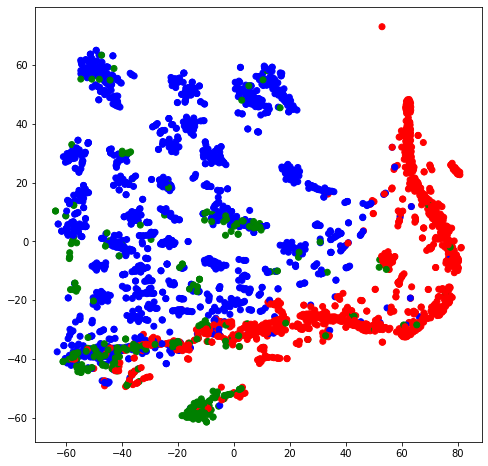

In [82]:
import matplotlib
plt.figure(figsize=(8, 8)) 
plt.scatter(x, y, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

In [ ]:
# x_check = [
#     'Tum hindu aurat ho',
#     'Tum sikh aurat ho',
#     'Tum muslim aurat ho',
#     'Tum hindu aadmi ho',
#     'Tum sikh aadmi ho',
#     'Tum muslim aadmi ho',
#     'Tum hindu hidje ho',
#     'Tum muslim hidje ho',
#     'Tum hindu chutiye hidje ho',
#     'Tum sikh chutiye aadmi ho',
#     'Tum muslim chutiye hidje ho'
# ]

# x_check = [
#     'Tum aadmi ho',
#     'Tum muslim aadmi ho',
# ]
x_check = [
    'porkistan ka rape start hone wala hai dekh ache se maa k loude hijde',
    'abe chutya bhool gaya kya kuwait war main muslim iraqi soldiers ne hi muslim kuwaiti aurat ka ladki logo ka rape Kiya tha',
    'muslim refugees are seeking refuge in christian countries ask yourself why are not they seeking refuge in muslim countries'
]

In [ ]:
for ix in range(len(x_check)):
    x_check[ix] = tokenizer.tokenize(x_check[ix])
    x_check[ix] = [lemmatizer.lemmatize(i) for i in x_check[ix]]
    
x_check = tokenizer_keras.texts_to_sequences(x_check)
x_check = sequence.pad_sequences(x_check, maxlen=len_max)

In [ ]:
abuse = np.zeros((len(x_check),209))
abuse[0, 20:22] = 1
abuse[1,35] = 1
test = model_fin.predict([x_check, abuse])

In [ ]:
test